In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#
from scipy.interpolate import interp1d

## The effect of massive neutrinos ##

We will use the [Cosmic Linear Anisotropy Solving System](http://class-code.net/) Boltzmann code to investigate the impact of massive neutrinos on (linear) cosmology.


In [2]:
# Import the Class class.
from classy import Class

Let's start by defining a "standard" cosmology.  We will work at fixed $\theta_\star$, since this is well known, and we will ask for the temperature Cls, lensing information and matter power spectrum information from $0<z<10$.  To begin, let's extract a bunch of properties for a fiducial cosmology -- then we will see how they change when varying $m_\nu$.

In [3]:
params = {
    'output': 'tCl lCl mPk',
    'lensing': 'yes',
    'P_k_max_h/Mpc': 5.,
    'z_pk': '0.0,10',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    '100*theta_s': 1.04,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
#
cc = Class()
cc.set(params)
cc.compute()
#

In [4]:
# The code gives us a whole lot of background cosmology information.
# Let's get the luminosity distance to z=1:
print("dL={:.2f}".format(cc.luminosity_distance(1.0)))
# Or the "angular" distance:
print("dA={:.2f}".format(cc.angular_distance(1.0)))
#
# And it has lots of other things it can tell you...
derived = cc.get_current_derived_parameters(['H0','Omega_m','Omega_Lambda',\
                                             'age','conformal_age','Neff',\
                                             'z_reio','100*theta_s','rs_rec','rs_d'])
print(derived)
#
# We can also do things like the growth factor and growth rate.
for zz in np.arange(0.0,2.01,0.5):
    print("At z={:4.1f}, D(z)={:8.4f}, f(z)={:8.4f}".\
          format(zz,cc.scale_independent_growth_factor(zz),\
                 cc.scale_independent_growth_factor_f(zz)))

dL=6829.10
dA=1707.28
{'H0': 67.08333825593147, 'Omega_m': 0.3162569432085949, 'Omega_Lambda': 0.6836625885093711, 'age': 13.840864956811735, 'conformal_age': 14191.572005319376, 'Neff': 3.045998221453432, 'z_reio': 7.8988800048828125, '100*theta_s': 1.0399988048076294, 'rs_rec': 144.6692553743839, 'rs_d': 147.21558118658146}
At z= 0.0, D(z)=  1.0000, f(z)=  0.5268
At z= 0.5, D(z)=  0.7691, f(z)=  0.7598
At z= 1.0, D(z)=  0.6072, f(z)=  0.8747
At z= 1.5, D(z)=  0.4963, f(z)=  0.9287
At z= 2.0, D(z)=  0.4179, f(z)=  0.9557


Let's plot a bunch of background cosmology information that will be helpful for understanding what's happening.

Text(0, 0.5, '$D(z)$')

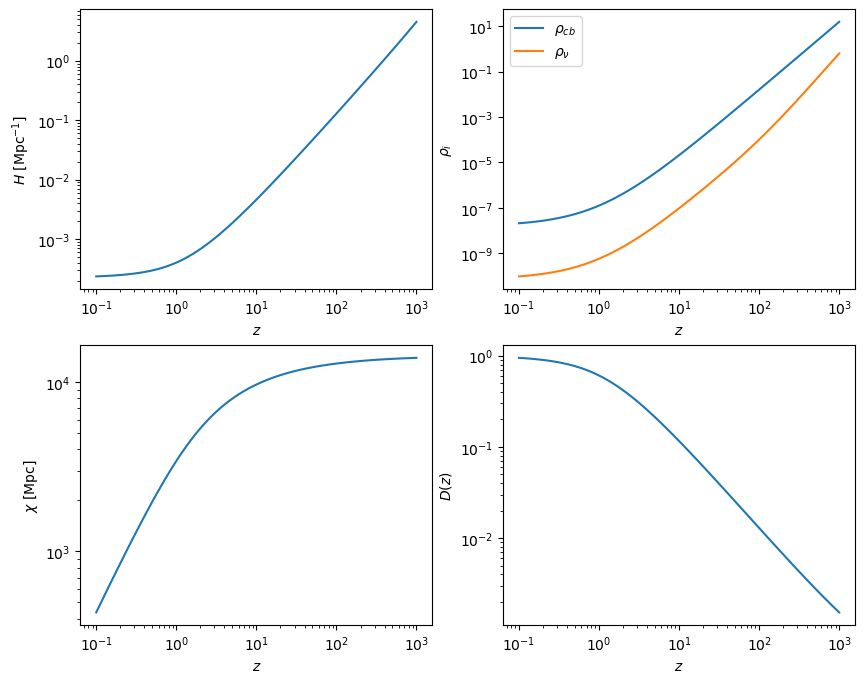

In [5]:
bkgnd = cc.get_background()
#
zvals = np.geomspace(0.1,1000,100)
hubble= interp1d(bkgnd['z'],bkgnd['H [1/Mpc]'])(zvals)
chi   = interp1d(bkgnd['z'],bkgnd['comov. dist.'])(zvals)
rhoc  = interp1d(bkgnd['z'],bkgnd['(.)rho_cdm'])(zvals)
rhob  = interp1d(bkgnd['z'],bkgnd['(.)rho_b'])(zvals)
rhonu = interp1d(bkgnd['z'],bkgnd['(.)rho_ncdm[0]'])(zvals)
Dz    = interp1d(bkgnd['z'],bkgnd['gr.fac. D'])(zvals)
#
fig,ax = plt.subplots(2,2,figsize=(10,8))
#
ax[0,0].plot(zvals,hubble   ,color='C0')
ax[1,0].plot(zvals,chi      ,color='C0')
ax[0,1].plot(zvals,rhoc+rhob,color='C0',label=r'$\rho_{cb}$')
ax[0,1].plot(zvals,rhonu    ,color='C1',label=r'$\rho_{\nu}$')
ax[1,1].plot(zvals,Dz       ,color='C0')
#
ax[0,1].legend()
#
for ir in range(ax.shape[0]):
    for ic in range(ax.shape[1]):
        ax[ir,ic].set_xscale('log')
        ax[ir,ic].set_yscale('log')
        ax[ir,ic].set_xlabel(r'$z$')
#
ax[0,0].set_ylabel(r'$H$ [Mpc${}^{-1}$]')
ax[1,0].set_ylabel(r'$\chi$ [Mpc]')
ax[0,1].set_ylabel(r'$\rho_i$')
ax[1,1].set_ylabel(r'$D(z)$')

Let's look at the CMB lensing potential power spectrum as well.  This can be converted to the deflection power spectrum by multiplying by $\ell(\ell+1)$ and the convergence ($\kappa$) power spectrum via
$$
  C_\ell^{\kappa\kappa} = \frac{1}{4} \frac{(\ell+2)!}{(\ell-2)!}\  C_\ell^{\phi\phi}
$$

Text(0, 0.5, '$10^7 C_\\ell^{\\kappa\\kappa}$')

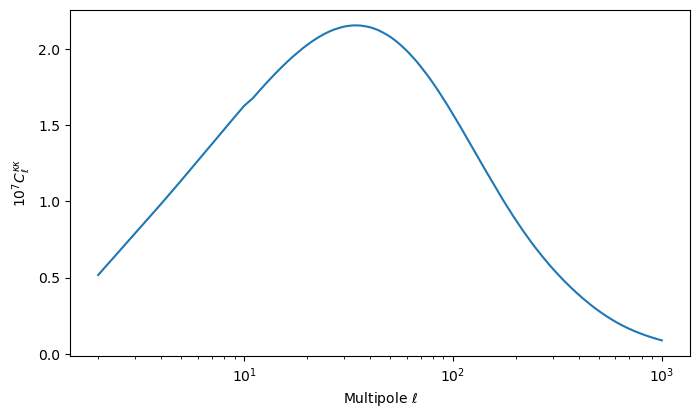

In [6]:
cls = cc.lensed_cl(1000)
ell = cls['ell'][2:]
fac = 0.25*(ell+2)*(ell+1)*(ell)*(ell-1)  # As per "explanatory.ini" in CLASS.
kap = cls['pp'][2:] * fac
#
fig,ax = plt.subplots(1,1,figsize=(8,4.5))
ax.plot(ell,1e7*kap)
ax.set_xscale('log')
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$10^7 C_\ell^{\kappa\kappa}$')

And the last quantity of interest for us is the matter power spectrum (here specifically the linear $P_{cb}$ spectrum).  For now we will follow the "LSS convention" of using $h^{-1}$Mpc units for $k$ and $P(k)$, but below we will switch this off because it introduces a $h^3$ factor in the normalization of $P(k)$ that somewhat obscures things.

Text(0, 0.5, '$P_{cb}(k)\\quad [h^{-3}{\\rm Mpc}^3]$')

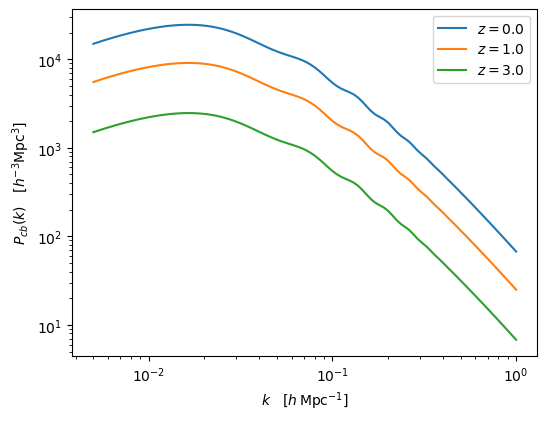

In [7]:
# Here's an example plotting the cold dark matter + baryon spectrum
# for a few different redshifts:
pkparams = {
    'output': 'mPk',
    'P_k_max_h/Mpc': 5.,
    'z_pk': '0.0,10',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
#
pkclass = Class()
pkclass.set(pkparams)
pkclass.compute()
#
kk = np.geomspace(0.005,1.0,100)
#
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
for zz in [0.0,1.0,3.0]:
    # If you have the non-linear flag set you can still get the linear version
    # by using pk_cb_lin, but if non-linear is not set this is what you get anyway.
    pkcb = np.array( [pkclass.pk_cb(k*pkparams['h'],zz)*pkparams['h']**3 for k in kk] )
    ax.plot(kk,pkcb,label="$z={:.1f}$".format(zz))
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{cb}(k)\quad [h^{-3}{\rm Mpc}^3]$')

## Varying neutrino mass ##

Now we can vary the mass of the neutrino and see how each of these quantities changes.  Here we will plot ratios to a fiducial case, and we will hold $\omega_{cdm}$, $\omega_b$ and $\theta_\star$ fixed.  What you choose to hold fixed does matter!  For light neutrinos, that are relativistic at last scattering, the physics at $z\sim 10^3$ is unchanged by varying $m_\nu$ and so to first approximation the CMB constrains $\omega_c$, $\omega_b$, etc.  This is "broken" by lensing of the CMB, that brings in sensitivity to lower redshifts when the neutrinos have gone non-relativistic and their mass matters.

To begin let's see how $\Omega_m$, $h$, etc. vary as we vary the neutrino mass at fixed "other parameters".

In [8]:
params = {
    'output': '',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    '100*theta_s': 1.04,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
#
for i,mnu in enumerate([0.02,0.04,0.06,0.08,0.10,0.12]):
    params['m_ncdm'] = mnu
    outstr = "mnu={:6.2f} meV: ".format(mnu)
    # This is very fast if we have output:''.
    cc = Class()
    cc.set(params)
    cc.compute()
    #
    derived = cc.get_current_derived_parameters(['H0','Omega_m','Omega_Lambda'])
    outstr += "h={:8.4f}, ".format(derived['H0']/100.)
    outstr += "OmM={:8.4f}, ".format(derived['Omega_m'])
    outstr += "OmL={:8.4f}".format(derived['Omega_Lambda'])
    print(outstr)

mnu=  0.02 meV: h=  0.6745, OmM=  0.3119, OmL=  0.6880
mnu=  0.04 meV: h=  0.6727, OmM=  0.3140, OmL=  0.6859
mnu=  0.06 meV: h=  0.6708, OmM=  0.3163, OmL=  0.6837
mnu=  0.08 meV: h=  0.6690, OmM=  0.3185, OmL=  0.6814
mnu=  0.10 meV: h=  0.6671, OmM=  0.3207, OmL=  0.6792
mnu=  0.12 meV: h=  0.6653, OmM=  0.3230, OmL=  0.6770


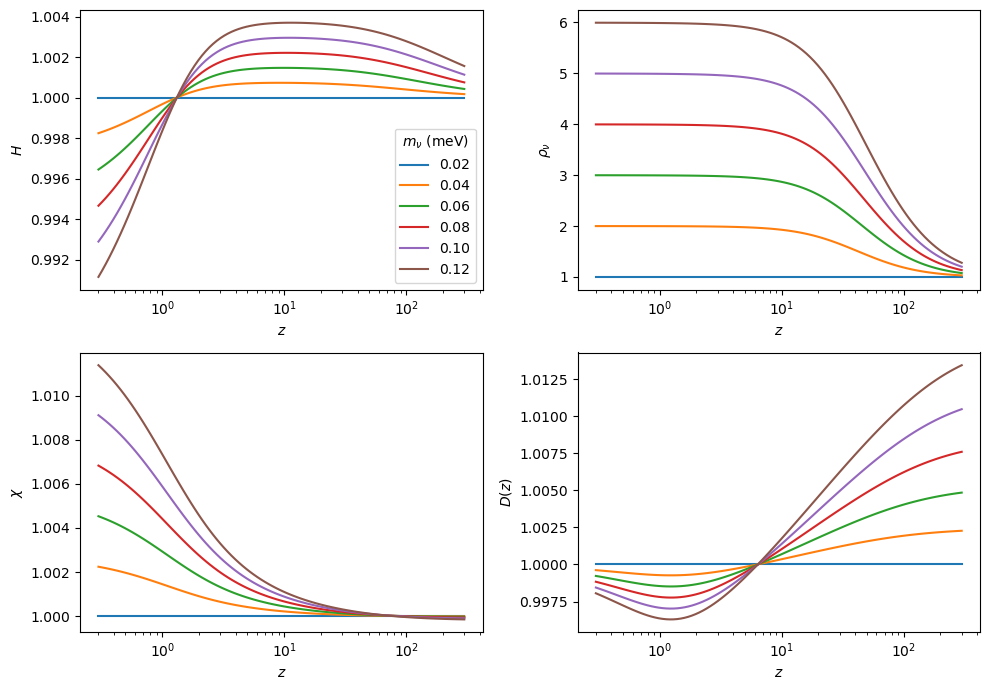

In [9]:
# First the background quantities:
params = {
    'output': '',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    '100*theta_s': 1.04,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
#
fig,ax = plt.subplots(2,2,figsize=(10,7))
#
# Now let's look through the neutrino masses, for now
# holding omega_cdm fixed.
zvals = np.geomspace(0.3,300,100)
for i,mnu in enumerate([0.02,0.04,0.06,0.08,0.10,0.12]):
    params['m_ncdm'] = mnu
    #
    cc = Class()
    cc.set(params)
    cc.compute()
    bkgnd = cc.get_background()
    icol  = 'C' + str( i%10 )
    #
    if i==0:
        hubblef=interp1d(bkgnd['z'],bkgnd['H [1/Mpc]'])(zvals)
        chif  = interp1d(bkgnd['z'],bkgnd['comov. dist.'])(zvals)
        rhocf = interp1d(bkgnd['z'],bkgnd['(.)rho_cdm'])(zvals)
        rhobf = interp1d(bkgnd['z'],bkgnd['(.)rho_b'])(zvals)
        rhonuf= interp1d(bkgnd['z'],bkgnd['(.)rho_ncdm[0]'])(zvals)
        Dzf   = interp1d(bkgnd['z'],bkgnd['gr.fac. D'])(zvals)
        # Note that D(z) is defined such that D(z=0)=1.
    hubble= interp1d(bkgnd['z'],bkgnd['H [1/Mpc]'])(zvals)
    chi   = interp1d(bkgnd['z'],bkgnd['comov. dist.'])(zvals)
    rhoc  = interp1d(bkgnd['z'],bkgnd['(.)rho_cdm'])(zvals)
    rhob  = interp1d(bkgnd['z'],bkgnd['(.)rho_b'])(zvals)
    rhonu = interp1d(bkgnd['z'],bkgnd['(.)rho_ncdm[0]'])(zvals)
    Dz    = interp1d(bkgnd['z'],bkgnd['gr.fac. D'])(zvals)
    #
    ax[0,0].plot(zvals,hubble/hubblef,color=icol,label='{:.2f}'.format(mnu))
    ax[1,0].plot(zvals,chi/chif      ,color=icol)
    ax[0,1].plot(zvals,rhonu/rhonuf  ,color=icol)
    ax[1,1].plot(zvals,Dz/Dzf        ,color=icol)
#
ax[0,0].legend(title=r'$m_{\nu}$ (meV)')
#
for ir in range(ax.shape[0]):
    for ic in range(ax.shape[1]):
        ax[ir,ic].set_xscale('log')
        ax[ir,ic].set_xlabel(r'$z$')
#
ax[0,0].set_ylabel(r'$H$')
ax[1,0].set_ylabel(r'$\chi$')
ax[0,1].set_ylabel(r'$\rho_{\nu}$')
ax[1,1].set_ylabel(r'$D(z)$')
#
plt.tight_layout()

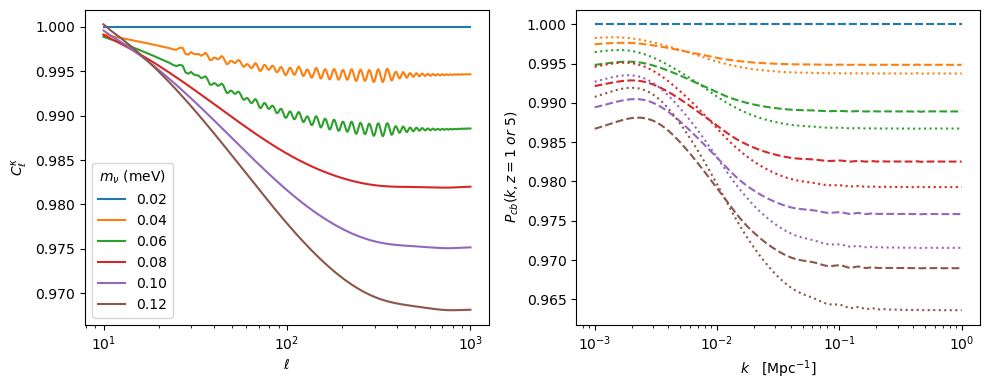

In [10]:
# Then the linear perturbations.
params = {
    'output': 'tCl lCl mPk',
    'lensing': 'yes',
    'P_k_max_h/Mpc': 5.,
    'z_pk': '0.0,10',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    '100*theta_s': 1.04,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
#
kk = np.geomspace(0.001,1.0,100)
#
fig,ax = plt.subplots(1,2,figsize=(10,4))
#
# Now let's look through the neutrino masses, for now
# holding omega_cdm fixed.
for i,mnu in enumerate([0.02,0.04,0.06,0.08,0.10,0.12]):
    params['m_ncdm'] = mnu
    #
    cc = Class()
    cc.set(params)
    cc.compute()
    hub   = cc.h()
    bkgnd = cc.get_background()
    icol  = 'C' + str( i%10 )
    #
    pkcblo= np.array( [cc.pk_cb(k,1.0) for k in kk] )
    pkcbhi= np.array( [cc.pk_cb(k,5.0) for k in kk] )
    #
    cls = cc.lensed_cl(1000)
    ell = cls['ell'][10:]
    fac = 0.25*(ell+2)*(ell+1)*(ell)*(ell-1)
    kap = cls['pp'][10:] * fac
    #
    if i==0:
        pkcblof = pkcblo
        pkcbhif = pkcbhi
        kapf  = kap
    ax[0].plot(ell,kap/kapf ,color=icol,label='{:.2f}'.format(mnu))
    ax[1].plot(kk,pkcblo/pkcblof,color=icol,ls=':')
    ax[1].plot(kk,pkcbhi/pkcbhif,color=icol,ls='--')
#
ax[0].legend(title=r'$m_{\nu}$ (meV)')
#
ax[0].set_xlabel(r'$\ell$')
ax[1].set_xlabel(r'$k\quad [{\rm Mpc}^{-1}]$')
ax[0].set_ylabel(r'$C_\ell^{\kappa}$')
ax[1].set_ylabel(r'$P_{cb}(k,z=1\ or\ 5)$')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#
plt.tight_layout()

# The End #